<center><h1>A Comprehensive Analysis of Convolutional Neural Networks</h1>
<h2>Matthias Bartolo</h2>

</center>

# Convolutional Neural Network (CNN)

This assignment is an _edited_ version of Tensorflow's official [CNN tutorial](https://www.tensorflow.org/tutorials/images/cnn). The goal of this assignment is to go through the notebook and fill in the empty code cells when prompted. Moreover, you will be asked to write down short comments on any notable observations in the _Comments_ section under each question.

As a precursor to starting this assignment, you can optionally go through the original notebook and read through any extra comments that might have been removed in this version.

This notebook can be run locally, or can be run from <b>Google Colab</b> which can be found [here](https://colab.research.google.com/drive/1PztXT1Xe7AMkNpy-O4tUAkn2wDfeI41H?usp=sharing).

### Import TensorFlow

In [1]:
from time import time
import tensorflow as tf
import numpy as np
import seaborn as sns

import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

print(tf.config.list_physical_devices('GPU'))

[]


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

170498071/170498071 [==============================] - 2s 0us/step


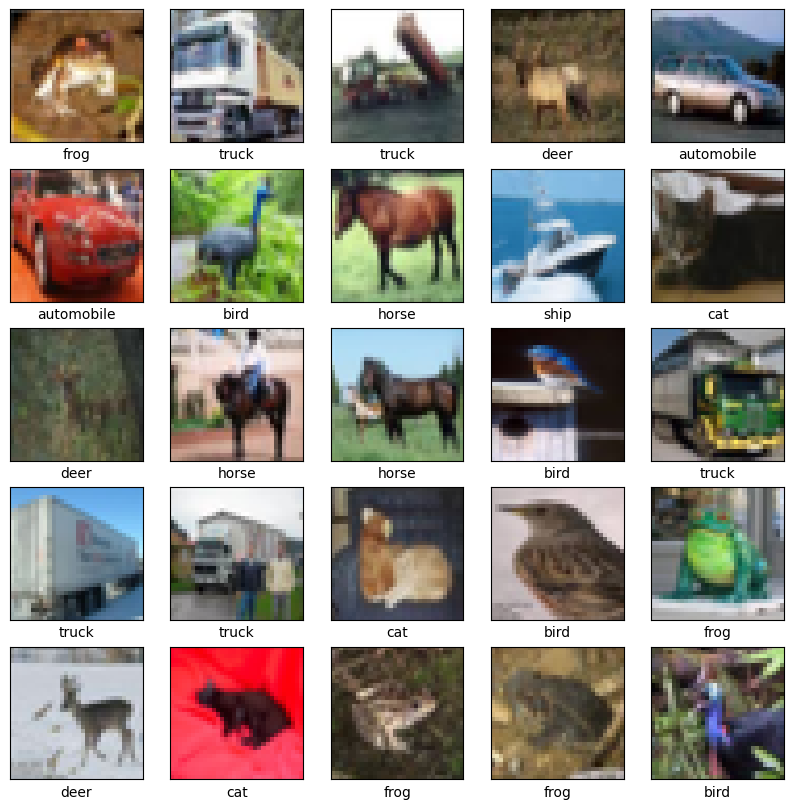

In [2]:
# Loading and splitting the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalizing pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Declaring the class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plotting the first 25 images from the training set and displaying the class name below each image
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Creating the model's architecture

In [3]:
def fit(model, epochs:int=100, optimizer=Adam(clipnorm=1.0), verbose:int=1, batch_size:int=32, callbacks=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), colors:tuple=('blue','purple','green','cyan'), do_display:bool=False, do_save:bool=False, save_name:str='model'):
    """Function which fits a model to the training data and plots the training process.

    Args:
        model (keras.model): Model to fit
        epochs (int, optional): Number of epochs to train for. Defaults to 10.
        optimizer (str, optional): Optimizer to use. Defaults to 'adam'.
        verbose (int, optional): Verbosity of training. Defaults to 1.
        batch_size (int, optional): Batch size. Defaults to 32.
        callbacks (list, optional): List of callbacks. Defaults to [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)].
        colors (tuple, optional): Colors to use for plotting. Defaults to ('blue','purple','green','cyan').`
        do_save (bool, optional): Whether to save the model. Defaults to False.
        save_name (str, optional): Name of the model to save. Defaults to 'model'.
    """

    # Loading the model
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    # Printing the model summary
    print(model.summary())

    # Setting the start time
    s=time()

    # Training Model
    history = model.fit(train_images, train_labels, epochs=epochs, verbose=verbose,
                        validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=callbacks)

    # Printing the training time
    print(f'\033[36mTraining Time: {round(time()-s,2)}s\033[0m')
    print('*'*50)

    # Plotting Training process
    plt.plot(history.history['accuracy'], label='Train Accuracy', color = colors[0])
    plt.plot(history.history['loss'], label = 'Train Loss', color = colors[1], linestyle='dashed')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = colors[2])
    plt.plot(history.history['val_loss'], label = 'Validation Loss', color = colors[3], linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Testing the model
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

    # Calculating the Precision, Recall and F1 Score
    y_pred = model.predict(test_images)
    y_pred = [np.argmax(i) for i in y_pred]
    
    # Printing the test results
    print(f'\033[35mTest Accuracy: {round(test_acc,2)}\033[0m')
    print(f'\033[34mTest Loss: {round(test_loss,2)}\033[0m')
    print(f'\033[33mTest Precision: {round(precision_score(test_labels, y_pred, average="weighted"),2)}\033[0m')
    print(f'\033[32mTest Recall: {round(recall_score(test_labels, y_pred, average="weighted"),2)}\033[0m')
    print(f'\033[31mTest F1 Score: {round(f1_score(test_labels, y_pred, average="weighted"),2)}\033[0m')

    # Plotting the confusion matrix
    if do_display:
        cm = confusion_matrix(test_labels, y_pred)
        plt.figure(figsize=(24,20))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    # Saving the model
    if do_save:
        model.save(f'{save_name}.h5')

In the original notebook, the below model configuration was used. 3 Convolution Layers were used to extract visual features from the image. Then these features are passed to a normal Neural Network which will learn to classify the different class labels.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

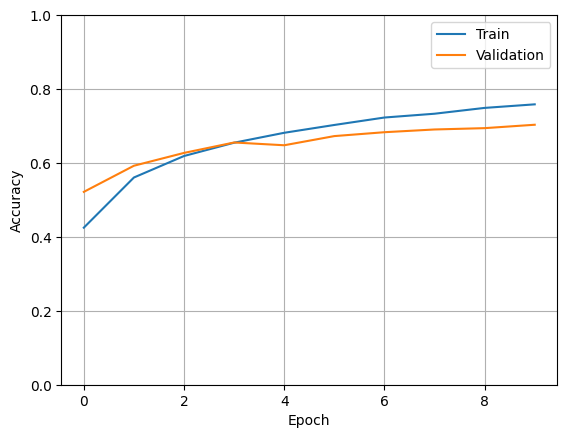

313/313 - 1s - loss: 0.8716 - accuracy: 0.7034 - 912ms/epoch - 3ms/step
Test Accuracy: 0.7


In [5]:
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model

### Q.1
Create a model architecture that has only one (Conv2D+MaxPooling2D) layer. Then. pass this model to the predefined <code>fit</code> function, which will train the model, display the training progress, and evaluate on the test set.  

Write down what differences you note between this model and the original one in the _Comments_ section.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                460864    
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 462410 (1.76 MB)
Trainable params: 462410 (1.76 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

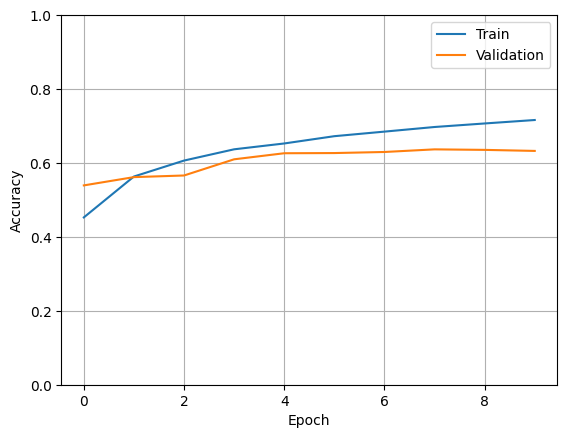

313/313 - 1s - loss: 1.0893 - accuracy: 0.6326 - 892ms/epoch - 3ms/step
Test Accuracy: 0.63


In [6]:
#Define Model and pass to 'fit' function
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model


##### Comments

->

### Q.2
The original CNN architecture used 32,64,64 output channels for each of the Convolution Layers respectively. Does increasing the output channels (eg. 128,256,256) boost performance on our small dataset? What happens when you decrease the output channels (eg. 8,16,16)?

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         590080    
                                                                 
 flatten_2 (Flatten)         (None, 4096)             

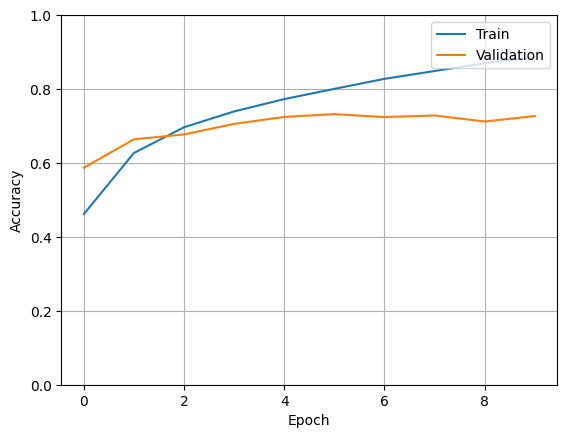

313/313 - 1s - loss: 1.0021 - accuracy: 0.7270 - 968ms/epoch - 3ms/step
Test Accuracy: 0.73


In [7]:
#Define Model with higher CNN output channels
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 8)         224       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 16)        1168      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 16)          2320      
                                                                 
 flatten_3 (Flatten)         (None, 256)              

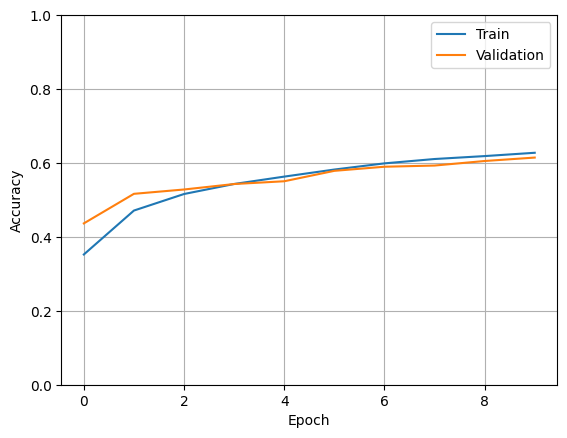

313/313 - 1s - loss: 1.0914 - accuracy: 0.6146 - 917ms/epoch - 3ms/step
Test Accuracy: 0.61


In [8]:
#Define Model with lower CNN output channels
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model


##### Comments

->

### Q.3
The Convolution Layers apply the _convolution_ operation on the image. Max-Pooling slides (in this case) a <code>2x2</code> window across the resulting convolution and takes only the maximum value. Max-Pooling adds translation invariance to the model - meaning translating the image by a small amount does not significnatly hinder performance.

Max-Pooling also helps reduce the size of the visual features, but having too large of a window might ignore more finer details of the object in the image. Show this empirically, by increasing the size of the <code>MaxPooling2D</code> sliding window and noting any changes in performance and time-efficiency. By looking at the original model's summary, we can see that the final <code>Conv2D</code> layer was outputting features in <code>4x4</code> matrices. Try and make the third <code>Conv2D</code> layer output <code>1x1</code> matrices of features instead, by editing some parameters of the <code>MaxPooling2D</code> layers.



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 6, 6, 64)          4160      
                                                                 
 flatten_4 (Flatten)         (None, 2304)             

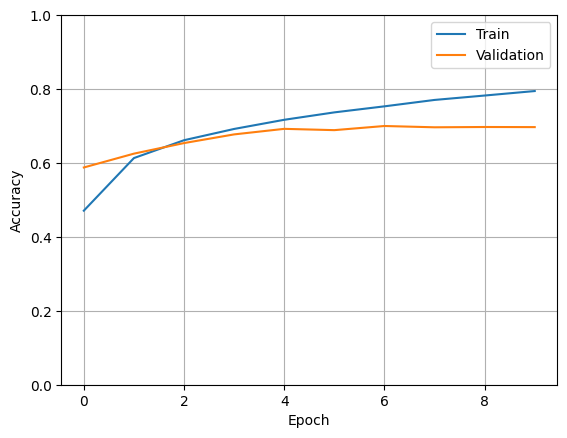

313/313 - 1s - loss: 0.9407 - accuracy: 0.6970 - 948ms/epoch - 3ms/step
Test Accuracy: 0.7


In [9]:
#Define Model with bigger MaxPooling Window.
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((1, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model



In [ ]:
#Define Model with bigger MaxPooling Window.
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((4, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model

##### Comments

->

### Q.4
Activation Functions are applied to the output of a neuron in a Neural Network. ReLU (Rectified Linear Unit) is one of the most popular activation functions used in Machine Learning. Experiment with another activation function of your choice and note any differences.

In [10]:
#Define Model with different activation function other than ReLU
activation_functions = ['relu', 'sigmoid', 'softmax', 'elu', 'selu', 'tanh', 'hard_sigmoid', 'softplus', 'softsign', 'swish']

for activation_function in activation_functions:

  model = models.Sequential()

  #Perform 2D Convolution + MaxPooling on the image, reducing its size.
  #These extract the most important visual features from the image.
  model.add(layers.Conv2D(32, (3, 3), activation=activation_function, input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation=activation_function))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation=activation_function))

  #Add Dense/Fully-Connected Layers.
  #These contian the 'classification' part of the model.
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation=activation_function))
  model.add(layers.Dense(10))

  fit(model,verbose=0)

  del model



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_5 (Flatten)         (None, 1024)             

KeyboardInterrupt: ignored

##### Comments

->

### Q.5
We have explored with improving the feautre detection process. Now let's turn our attention to the _classifier_ part; the final fully-connected layer. After flattening the features into a 1-D vector, can you modify the final dense layer (change number of neurons, add more layers, etc.) and describe how this affects the performance of the model?

Note: The final output of the dense layer must still be 10, as this is the number of classes in our _CIFAR10_ dataset.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 7200)              0         
                                                                 
 dense_12 (Dense)            (None, 32)                230432    
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                                 
Total params: 231658 (904.91 KB)
Trainable params: 231658 (904.91 KB)
Non-trainable params: 0 (0.00 Byte)
______________

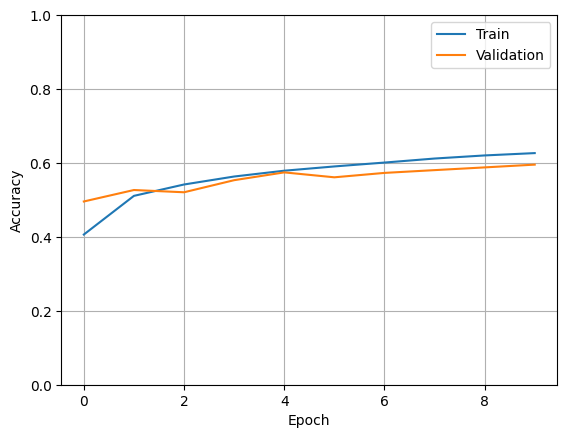

313/313 - 1s - loss: 1.1417 - accuracy: 0.5955 - 843ms/epoch - 3ms/step
Test Accuracy: 0.6


In [11]:
#Define Model with modified dense layers (Reducing the number of neurons)
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 7200)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               921728    
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
Total params: 923914 (3.52 MB)
Trainable params: 923914 (3.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

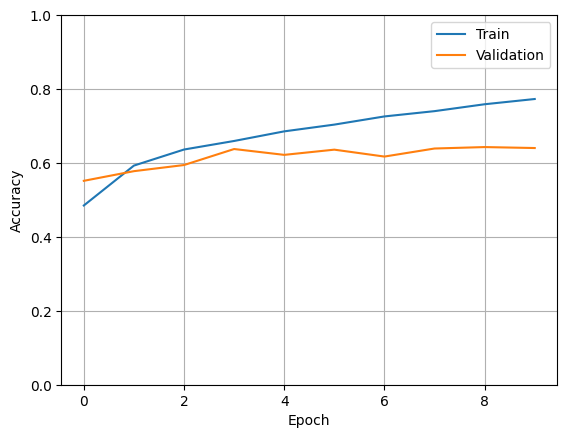

313/313 - 1s - loss: 1.1413 - accuracy: 0.6404 - 635ms/epoch - 2ms/step
Test Accuracy: 0.64


In [12]:
#Define Model with modified dense layers (Adding the number of neurons)
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 7200)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                460864    
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                      

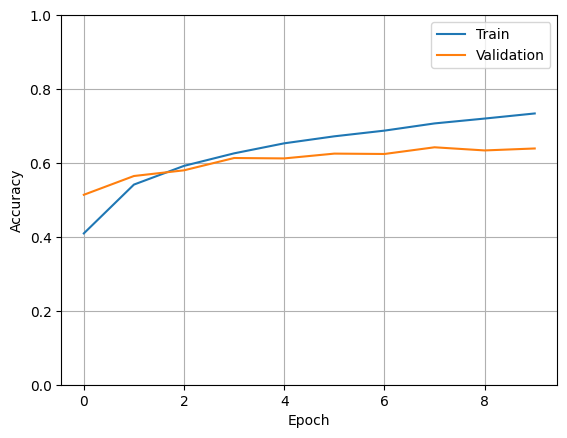

313/313 - 1s - loss: 1.0945 - accuracy: 0.6392 - 663ms/epoch - 2ms/step
Test Accuracy: 0.64


In [13]:
#Define Model with modified dense layers (Adding extra layers)
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10))

fit(model,verbose=0)

del model

##### Comments

->

### Q.6
In a Neural Network, the optimizer is the heuristic function used to 'push' the model down the right path. Compare two versions of an architecture of your choice that use different optimizers. This can be done by setting the <code>optimizer</code> parameter in the <code>fit</code> function (eg. <code>optimizer='sgd'</code>).

In [ ]:
#Define Model with Optimizer list
optimizers = [SGD(), RMSprop(), Adagrad(), Adadelta(), Adam(), Adamax(), Nadam()]

for optimizer in optimizers:
  #Define Model and pass to 'fit' function
  model = models.Sequential()

  #Perform 2D Convolution + MaxPooling on the image, reducing its size.
  #These extract the most important visual features from the image.
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  #Add Dense/Fully-Connected Layers.
  #These contian the 'classification' part of the model.
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10))

  fit(model,verbose=0, optimizer=optimizer)

  del model




##### Comments

->

### Q.7
The original CNN architecture managed to achieve ~70% accuracy on the test set using 122,570 model parameters. Can you define your own CNN architecture and try to improve on the original model? Improvements include: achieving higher performance on the test set, comparable performance using significantly fewer model parameters, faster training time, different model architecture, etc...

Note down which factors of your CNN architecture you found to be the most responsible for contributing to model performance.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

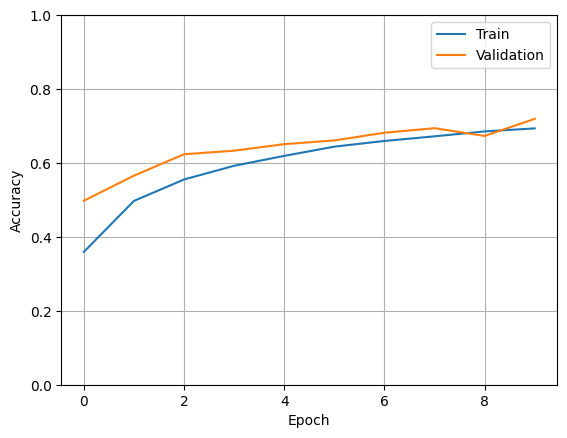

313/313 - 1s - loss: 0.8267 - accuracy: 0.7194 - 976ms/epoch - 3ms/step
Test Accuracy: 0.72


In [4]:
#Define Custom CNN Model
model = models.Sequential()

#Perform 2D Convolution + MaxPooling on the image, reducing its size.
#These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Add Dense/Fully-Connected Layers.
#These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# Adding Dropout for regularization
model.add(layers.Dropout(0.5))

# Adding BatchNormalization for regularization
model.add(layers.BatchNormalization())

model.add(layers.Dense(10))

fit(model,verbose=0)

del model


##### Comments

->